In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
discussion_data = pd.read_csv("github_discussion_data.csv")
discussion_data.head()

,Title,Discussion ID,Created At,User ID,Comment Count,Answered/Unanswered,Comment ID,Comment Author,Comment Text
0,Localization Architecture Design,D_kwDOAnasMc4AP640,2021-12-22T10:22:48Z,mitsudome-r,4,Answered,NaN,NaN,NaN
1,Localization Architecture Design,D_kwDOAnasMc4AP640,2021-12-22T10:22:48Z,mitsudome-r,4,Answered,DC_kwDOAnasMc4AHFoI,mitsudome-r,Here's the meeting minutes from the discussion...
2,Localization Architecture Design,D_kwDOAnasMc4AP640,2021-12-22T10:22:48Z,mitsudome-r,4,Answered,DC_kwDOAnasMc4AIFQu,xczhanjun,How about add an end 2 end AI module together ...
3,Localization Architecture Design,D_kwDOAnasMc4AP640,2021-12-22T10:22:48Z,mitsudome-r,4,Answered,DC_kwDOAnasMc4AI3TZ,xmfcx,@xczhanjun As long as it can replicate the inp...
4,Localization Architecture Design,D_kwDOAnasMc4AP640,2021-12-22T10:22:48Z,mitsudome-r,4,Answered,DC_kwDOAnasMc4AIdYt,maxime-clem,I would like to propose an additional feature:...


In [45]:
# We want to primarily focus on those discussions that have been answered - those are the most informative
answered_discussion_data = discussion_data[discussion_data['Answered/Unanswered'] == 'Answered']

# This gives us the user IDs of those whose discussions generate the most comments
gb_df_1 = answered_discussion_data.groupby('User ID')['Comment Author'].count().reset_index()
gb_df_1 = gb_df_1[gb_df_1['User ID'] != "Unknown"]
gb_df_1 = gb_df_1.sort_values(by='Comment Author', ascending=False, ignore_index=True)
gb_df_1.head()

,User ID,Comment Author
0,xmfcx,186
1,kaspermeck-arm,167
2,kminoda,118
3,MrOCW,107
4,zillur-av,91


In [71]:
# This groupby generates the number of comments specific individuals make on a certain person's discussions
# (can be used to measure collaboration index and define weight edges for a graph when normalized)
gb_df_2 = answered_discussion_data.groupby(['User ID', 'Comment Author'])['Comment ID'].count().reset_index()
gb_df_2 = gb_df_2[gb_df_2["User ID"] != gb_df_2["Comment Author"]]
gb_df_2 = gb_df_2[(gb_df_2["User ID"] != "Unknown") & (gb_df_2["Comment Author"] != "Unknown")]
gb_df_2 = gb_df_2.sort_values(by='Comment ID', ascending=False, ignore_index=True)

# Could be used for PageRank initialization
total_comments = gb_df_2["Comment ID"].sum()
gb_df_2["Normalized Comment ID"] = gb_df_2['Comment ID'] / total_comments

gb_df_2.head(100)

,User ID,Comment Author,Comment ID,Normalized Comment ID
0,kaspermeck-arm,doganulus,36,0.015776
1,kaspermeck-arm,kenji-miyake,28,0.012270
2,isamu-takagi,kenji-miyake,26,0.011394
3,Hensbag,muratgozum45,20,0.008764
4,zillur-av,KYabuuchi,19,0.008326
...,...,...,...,...
95,xmfcx,miursh,5,0.002191
96,HuaweiAlgolux,takayuki5168,5,0.002191
97,VRichardJP,kminoda,4,0.001753
98,VRichardJP,xmfcx,4,0.001753


In [62]:
# Now, we want to evaluate the informativeness of a user's comments overall - we can do so by measuring total length of comments
gb_df_3 = answered_discussion_data.groupby('Comment Author', group_keys=False)['Comment Text']
# gb_df_3 = gb_df_3.apply(lambda x: x.str.count('\n') + 1).reset_index(name='comment_line_counts')
gb_df_3.head(20)

1       Here's the meeting minutes from the discussion...
2       How about add an end 2 end AI module together ...
3       @xczhanjun As long as it can replicate the inp...
4       I would like to propose an additional feature:...
5            @YamatoAndo Do you have any opinion on this?
                              ...                        
4814    I am using Carla on a Ubuntu 20 computer with ...
4815    I have been able to tune properly the CycloneD...
4837    Hello!\nI'll leave here the updated diagrams p...
4857    I have compared the trajectory that autoware w...
4865    - Presentation from Mert Colak (LeoDrive)\n  -...
Name: Comment Text, Length: 2047, dtype: object

## **Networked Analysis** ##

In [51]:
import networkx as nx

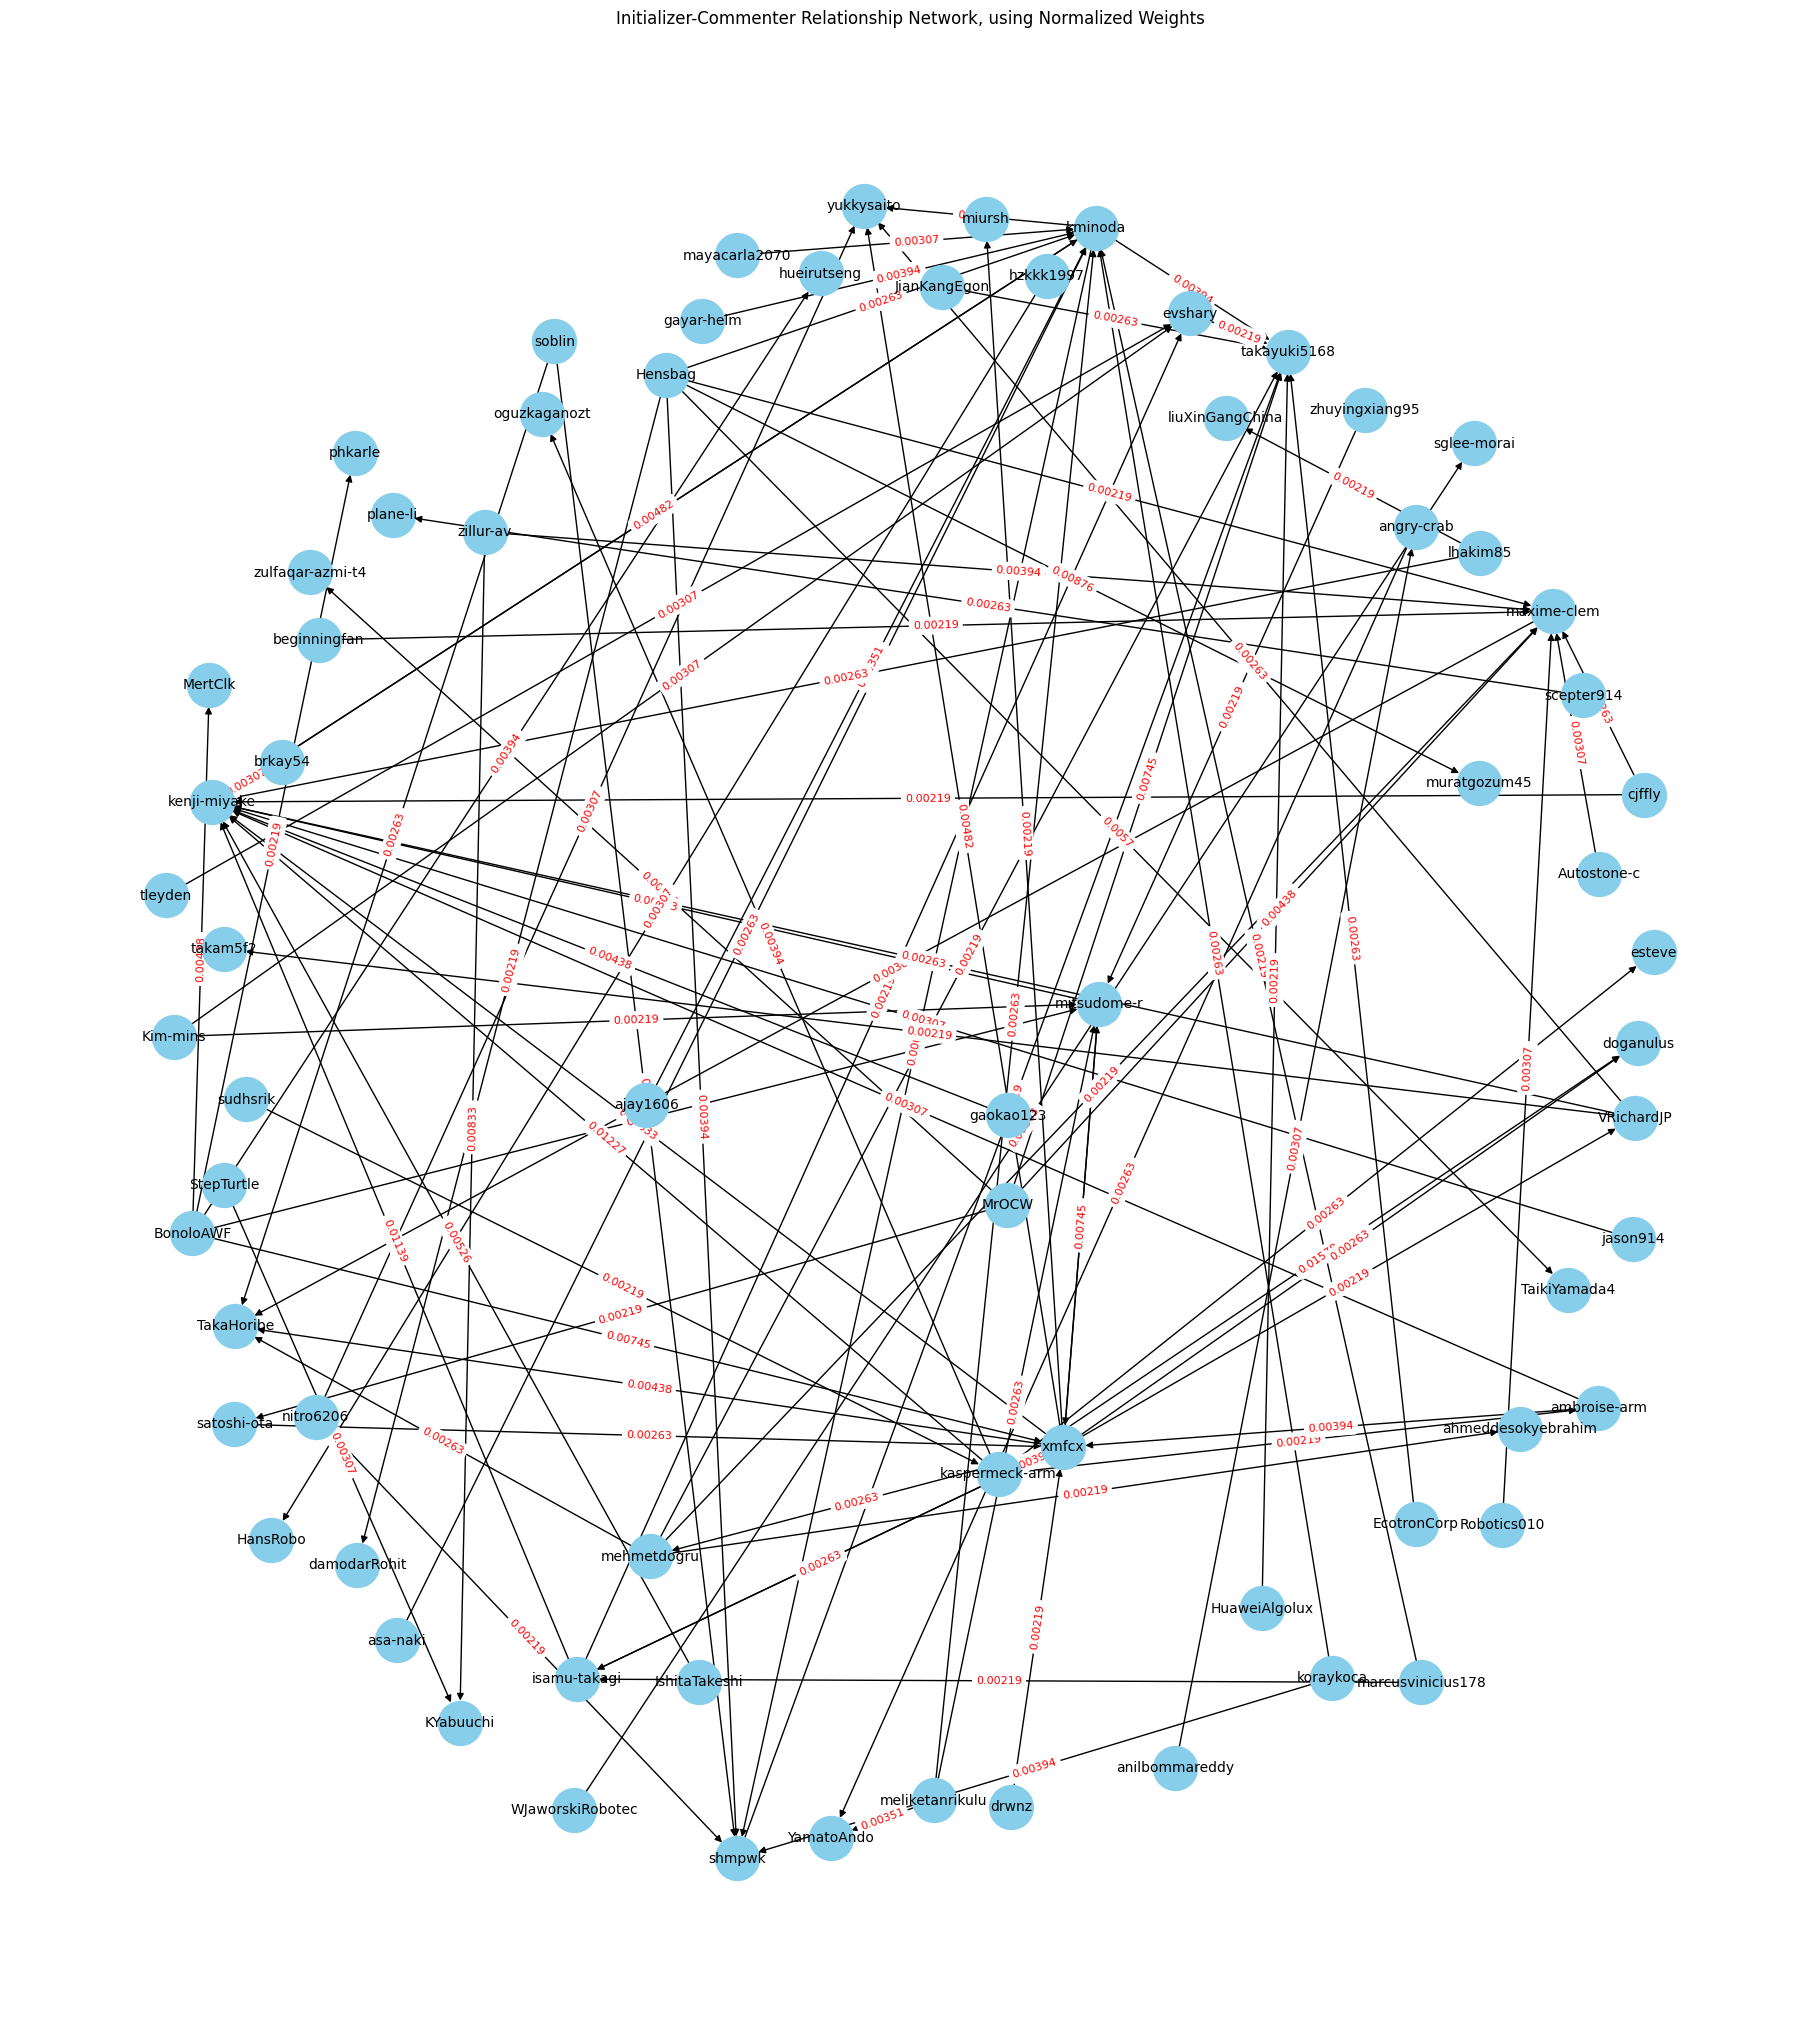

In [94]:
# Now, use the nx library to created a directed graph (DiGraph) that we can then use to run PageRank/Gini coefficient analyses
# and generate other networked level metrics
G = nx.DiGraph()

# Iterate through gb_df_2 to create a sample network and
for index, row in gb_df_2.iterrows():
  src_node = row["User ID"]
  tgt_node = row["Comment Author"]
  weight = row["Normalized Comment ID"]

  if weight > 0.002:
    G.add_edge(src_node, tgt_node, weight=weight)

# # To list the values of weights along each edge
# for src, tgt, data in G.edges(data=True):
#     edge_weight = data['weight']
#     print(f"Edge from {src} to {tgt} has weight {edge_weight}")

# To print the names of all nodes
all_nodes = list(G.nodes())

# Draw the graph
pos = nx.spring_layout(G, k=0.25)  # You can experiment with the 'k' parameter
labels = {node: node for node in all_nodes}
plt.figure(figsize=(18, 20))  # Adjust the figure size as needed
nx.draw(G, pos, with_labels=True, labels=labels, node_size=1000, node_color='skyblue', font_size=10, font_color='black')
edge_labels = {(src, tgt): round(data['weight'], 5) for src, tgt, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')
plt.title("Initializer-Commenter Relationship Network, using Normalized Weights")
plt.show()